# MLP Network


## 1. Pretreatment


Read data from `.mat` files.

In [1]:
import scipy as sp
import torch
import torch.nn as nn
import numpy as np
from torchinfo import summary

torch.set_default_dtype(torch.float64)
Input = sp.io.loadmat("Data/KinematicsData.mat")
Input = Input["KinematicsData"]
Output = sp.io.loadmat("Data/DynRegVecData.mat")
Output = Output["DynRegData"]

Generate higher order terms of velocity.


In [2]:
def VelocityHigherOrder(Data):
    num_Dof = int(Data.shape[1] / 3)

    Data_Processed_Left = Data[:, 0:num_Dof]
    Data_Processed_Right = Data[:, -num_Dof:]

    VelocityData = Data[:, num_Dof : 2 * num_Dof]
    Data_Processed_Mid = np.zeros((Data.shape[0], int(num_Dof * (num_Dof + 1) / 2)))

    col_index = 0
    for i in range(num_Dof):
        for j in range(i, num_Dof):
            Data_Processed_Mid[:, col_index] = VelocityData[:, i] * VelocityData[:, j]
            col_index += 1

    return np.concatenate(
        (Data_Processed_Left, Data_Processed_Mid, Data_Processed_Right), axis=1
    )


Input = VelocityHigherOrder(Input)

Size of input and output data.

In [3]:
import sys

sys.path.append("..")
from utils import *

Input.shape, Output.shape
Input = torch.from_numpy(Input).to(GET_DEVICE())
Output = torch.from_numpy(Output).to(GET_DEVICE())

Create **Training** and **Validation** datasets.

In [4]:
TrainingLoader, ValidationLoader = Split2Loaders(
    Input, Output, BATCHSIZE=32, RATIO=0.8, SHUFFLE=True
)

## 2. Training


Define MLP network structure.

In [5]:
class DynReg_MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=None):
        if hidden_size is None:
            hidden_size = [16, 32, 16]
        super().__init__()

        # 创建一个线性层的列表
        self.layers = nn.ModuleList()

        self.LinearLayerStruct = [input_size] + hidden_size + [output_size]

        for i in range(len(self.LinearLayerStruct) - 1):
            self.layers.append(
                nn.Linear(self.LinearLayerStruct[i], self.LinearLayerStruct[i + 1])
            )

    def forward(self, x):
        Output = x
        for layer in self.layers:
            Output = layer(Output)
            Output = torch.relu(Output)
        return Output

Define network.

In [6]:
Net = DynReg_MLP(
    input_size=Input.shape[1], output_size=Output.shape[1], hidden_size=[32, 64, 64]
)
summary(
    Net,
    input_data=torch.zeros(1, Input.shape[1]),
    device=GET_DEVICE(),
    col_names=["input_size", "output_size", "num_params"],
    col_width=15,
)

Layer (type:depth-idx)                   Input Shape     Output Shape    Param #
DynReg_MLP                               [1, 7]          [1, 14]         --
├─ModuleList: 1-1                        --              --              --
│    └─Linear: 2-1                       [1, 7]          [1, 32]         256
│    └─Linear: 2-2                       [1, 32]         [1, 64]         2,112
│    └─Linear: 2-3                       [1, 64]         [1, 64]         4,160
│    └─Linear: 2-4                       [1, 64]         [1, 14]         910
Total params: 7,438
Trainable params: 7,438
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.06

Define optimizer.

In [7]:
optimizer = torch.optim.Adam(Net.parameters(), lr=0.001, weight_decay=0)

Initialize weight.

In [8]:
INIT_WEIGHTS_XAVIER(Net)

Define training configuration.

In [9]:
num_epochs = 20

Training network.

In [10]:
(
    Loss_Training_History,
    Loss_Validation_History,
) = TRAIN_WITH_PROGRESS_BAR_ONE_LOSS(
    MODEL=Net,
    NUM_EPOCHS=num_epochs,
    OPTIMIZER=optimizer,
    TRAIN_LOADER=TrainingLoader,
    VALIDATION_LOADER=ValidationLoader,
    LOSS_TYPE=nn.MSELoss(),
    DEVICE=0,
)

PyTorch Version: 2.2.2
Training on cuda:0
====================================Start training====================================


Epoch 20/20: 100%|██████████| 1250/1250 [00:04<00:00, 264.49batch/s, loss=31.4]


====================================Finish training====================================



Visualization.

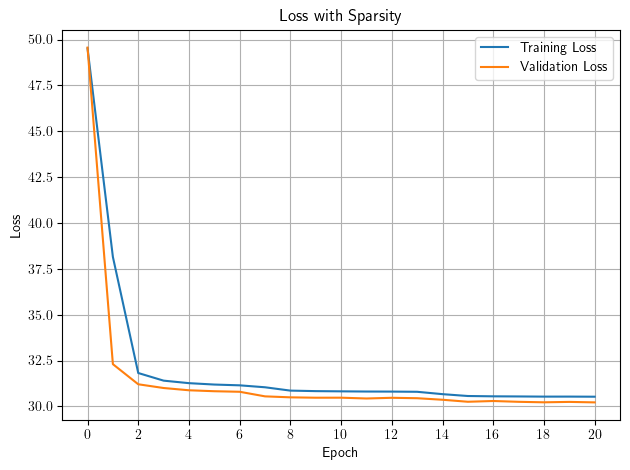

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["text.usetex"] = True
x_axis_segments = 10

plt.plot(
    np.arange(0, len(Loss_Training_History)),
    Loss_Training_History,
    label="Training Loss",
)
plt.plot(
    np.arange(0, len(Loss_Validation_History)),
    Loss_Validation_History,
    label="Validation Loss",
)
plt.title("Loss with Sparsity")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(np.linspace(0, num_epochs, x_axis_segments + 1, dtype=int))
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Final loss.

In [12]:
Loss_Validation_History[-1]

tensor(30.2205)

Linear Layer Weight Visualization.

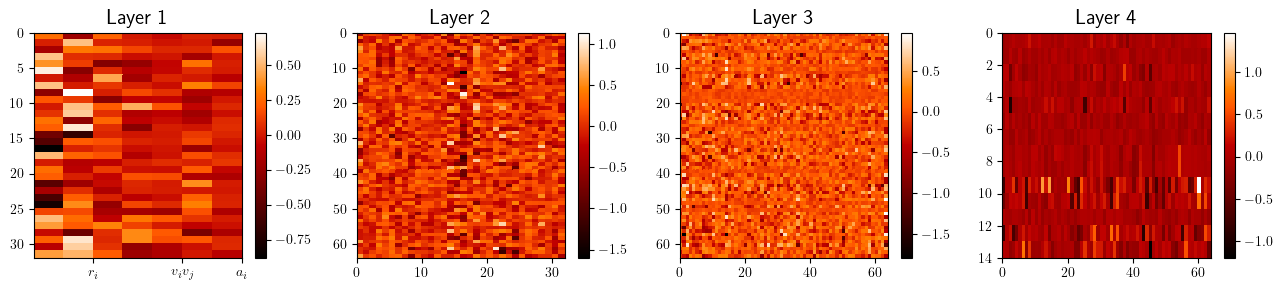

In [13]:
fig, ax = plt.subplots(
    1, len(Net.layers), figsize=(3 * len(Net.layers) + 1, 3), dpi=100
)

for index, layer in enumerate(Net.layers):
    CurrentPlot = ax[index].pcolor(
        layer.weight.detach().to("cpu").numpy(), cmap="gist_heat"
    )
    ax[index].invert_yaxis()
    ax[index].set_title(f"Layer {str(index + 1)}", fontsize=15)
    plt.colorbar(CurrentPlot, ax=ax[index])
    if index == 0:
        ax[index].set_xticks([2, 5, 7])
        ax[index].set_xticklabels([r"$r_i$", r"$v_i v_j$", r"$a_i$"])
plt.tight_layout()